### Prophet

- 페이스북에서 공개한 시계열 예측 라이브러리
- Prophet 모델의 주요 구성요소는 경향성(Trend), 계절성(Seasonality), 휴일(Holiday)로, 에너지 빈곤층 기준은 추세와 계절성을 포함하는 시계열데이터이기에 적용해보았음.


***할일***
- ppt 내용정리(done)
- 저장한 예측데이터로 합산점수를 내고 순위예측할것(done)

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,534 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160983 files and d

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

### 데이터정제

In [3]:
path = 'https://raw.githubusercontent.com/soohyeony/ds_energy/main/%EC%A0%84%EC%B2%B4%EA%B8%B0%EA%B0%84%EC%A0%90%EC%88%98%ED%95%A9%EC%82%B0.csv'
df = pd.read_csv(path, header=0)
print(df.shape)
print(df.head())

(1200, 7)
       년월 자치구명  에너지바우처점수  최소에너지점수  연료비비율점수  점수합계    percent
0  201601  강남구         3        4        1     8  26.666667
1  201601  강동구         2        5        1     8  26.666667
2  201601  강북구         4        5        1    10  33.333333
3  201601  강서구         6        5        1    12  40.000000
4  201601  관악구         3        6        1    10  33.333333


In [4]:
# 년월 int -> object
df["년월"] = df["년월"].astype(str)
df.info()

# raw_total["연월_datetime"] = raw_total["연월_object"].apply(pd.to_datetime) 
# raw_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년월        1200 non-null   object 
 1   자치구명      1200 non-null   object 
 2   에너지바우처점수  1200 non-null   int64  
 3   최소에너지점수   1200 non-null   int64  
 4   연료비비율점수   1200 non-null   int64  
 5   점수합계      1200 non-null   int64  
 6   percent   1200 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 65.8+ KB


In [5]:
# 년월 YYYY-mm-dd 형식으로 변경
df["연도"] = df["년월"].str.slice(start=0,stop=4)
df["월"] = df["년월"].str.slice(start=4,stop=6)
df["연월_object"] = df["연도"] + '-' + df["월"] + '-01'
df.head()

,년월,자치구명,에너지바우처점수,최소에너지점수,연료비비율점수,점수합계,percent,연도,월,연월_object
0,201601,강남구,3,4,1,8,26.666667,2016,01,2016-01-01
1,201601,강동구,2,5,1,8,26.666667,2016,01,2016-01-01
2,201601,강북구,4,5,1,10,33.333333,2016,01,2016-01-01
3,201601,강서구,6,5,1,12,40.000000,2016,01,2016-01-01
4,201601,관악구,3,6,1,10,33.333333,2016,01,2016-01-01


In [6]:
#  datetime형식 추가
df["연월_datetime"] = df["연월_object"].apply(pd.to_datetime) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   년월           1200 non-null   object        
 1   자치구명         1200 non-null   object        
 2   에너지바우처점수     1200 non-null   int64         
 3   최소에너지점수      1200 non-null   int64         
 4   연료비비율점수      1200 non-null   int64         
 5   점수합계         1200 non-null   int64         
 6   percent      1200 non-null   float64       
 7   연도           1200 non-null   object        
 8   월            1200 non-null   object        
 9   연월_object    1200 non-null   object        
 10  연월_datetime  1200 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 103.2+ KB


In [7]:
# 구 단위 코드화; 강남구-1, 중랑구-25
guList = ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']
code = 1
for gu in guList:
  df.loc[(df["자치구명"] == gu), "구별코드"] = code
  code += 1

df["구별코드"] = df["구별코드"].astype('int')
df.head(5)

,년월,자치구명,에너지바우처점수,최소에너지점수,연료비비율점수,점수합계,percent,연도,월,연월_object,연월_datetime,구별코드
0,201601,강남구,3,4,1,8,26.666667,2016,01,2016-01-01,2016-01-01,1
1,201601,강동구,2,5,1,8,26.666667,2016,01,2016-01-01,2016-01-01,2
2,201601,강북구,4,5,1,10,33.333333,2016,01,2016-01-01,2016-01-01,3
3,201601,강서구,6,5,1,12,40.000000,2016,01,2016-01-01,2016-01-01,4
4,201601,관악구,3,6,1,10,33.333333,2016,01,2016-01-01,2016-01-01,5


### 2020 에너지바우처 점수예측

In [8]:
# 예측 input data 생성

year_2020 = list()
for i in range(1, 13):
    year_2020.append(['2020-%02d' % i])
year_2020 = pd.DataFrame(year_2020, columns = ['ds'])
year_2020['ds']= pd.to_datetime(year_2020['ds'])
year_2020

,ds
0,2020-01-01
1,2020-02-01
2,2020-03-01
3,2020-04-01
4,2020-05-01
5,2020-06-01
6,2020-07-01
7,2020-08-01
8,2020-09-01
9,2020-10-01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarn

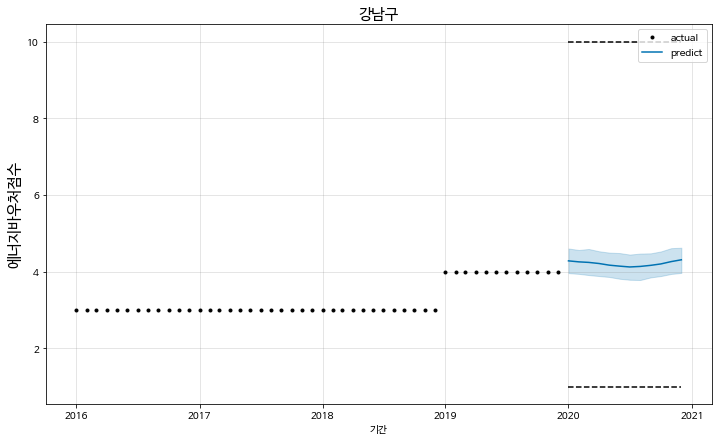

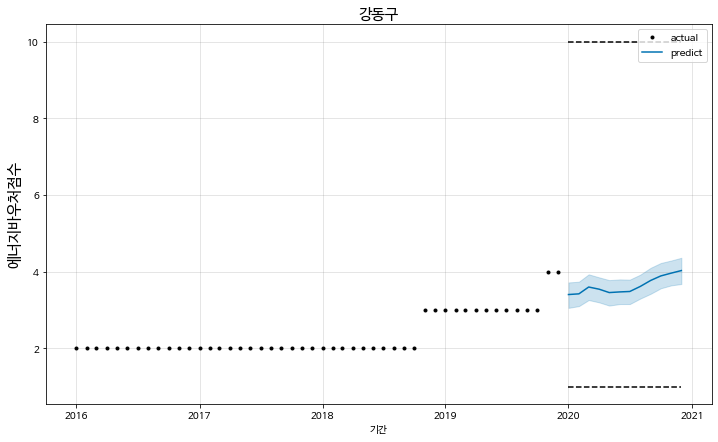

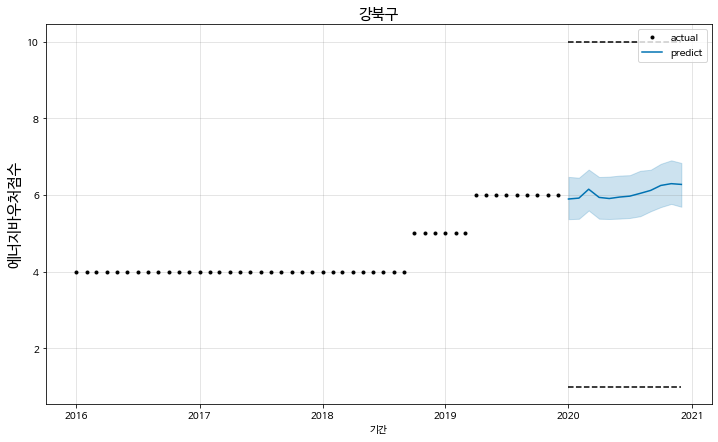

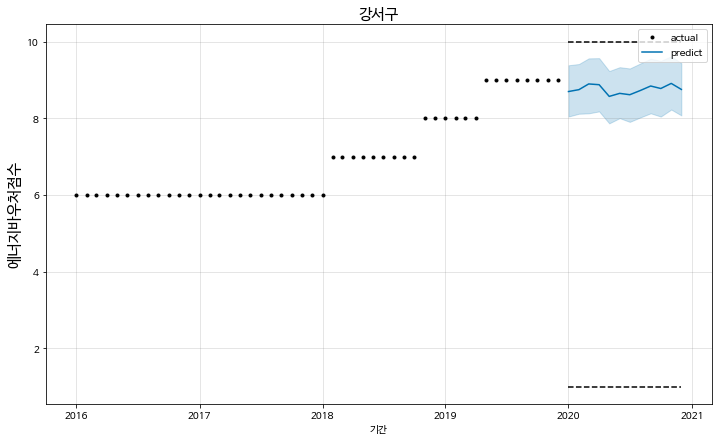

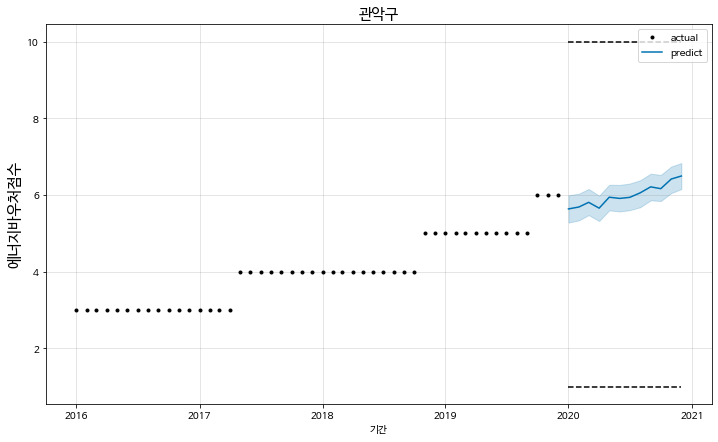

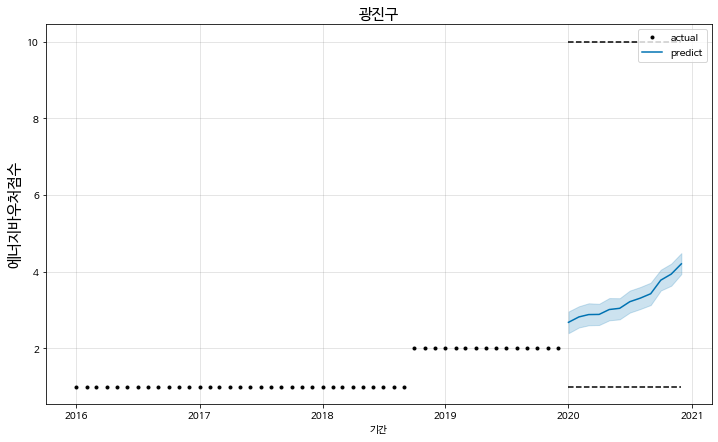

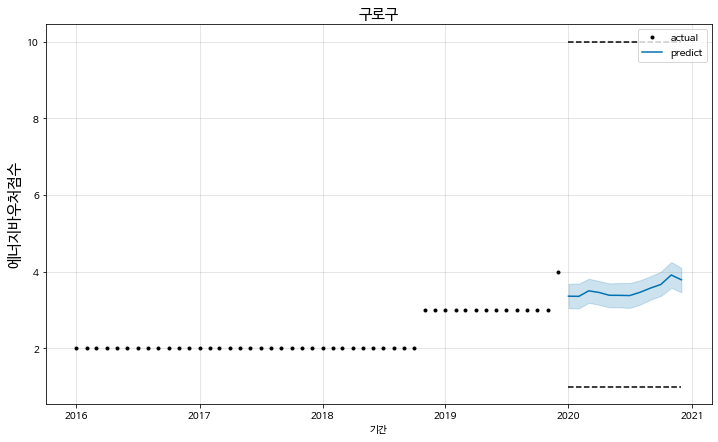

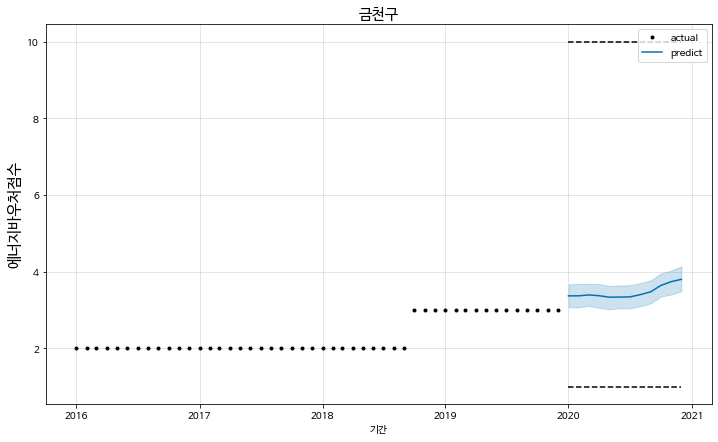

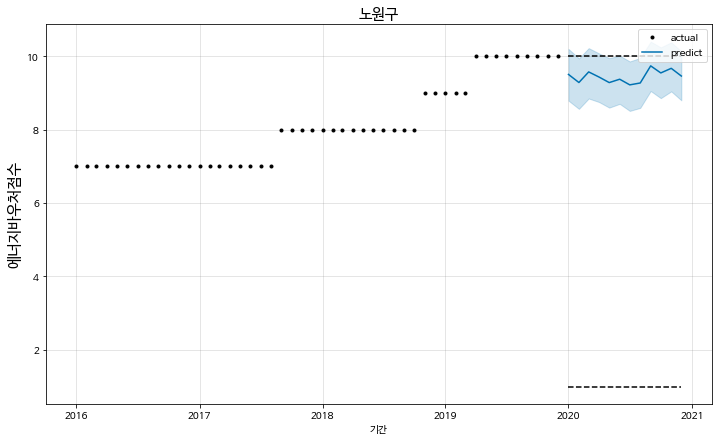

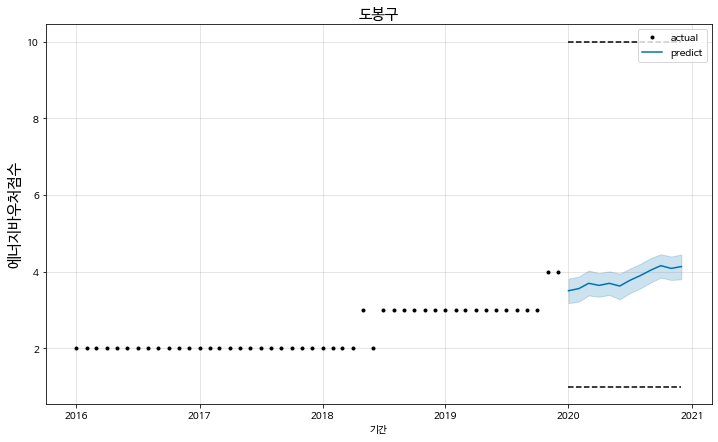

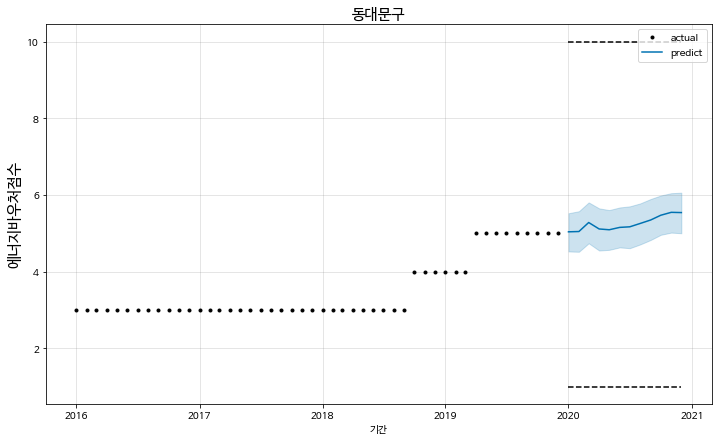

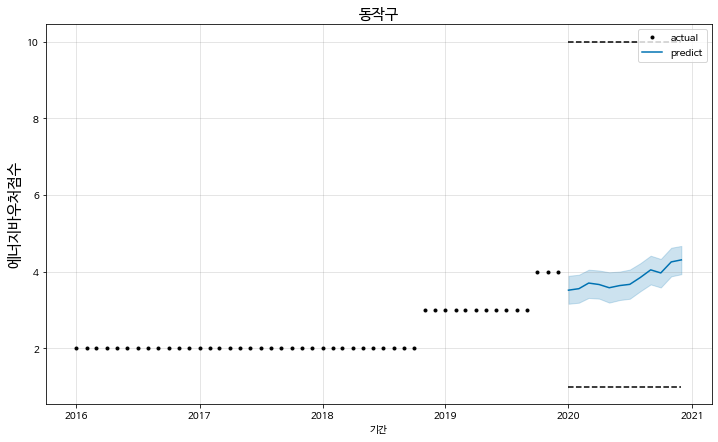

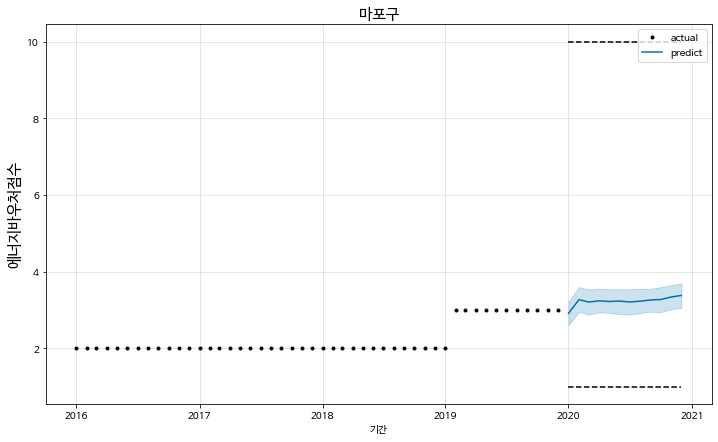

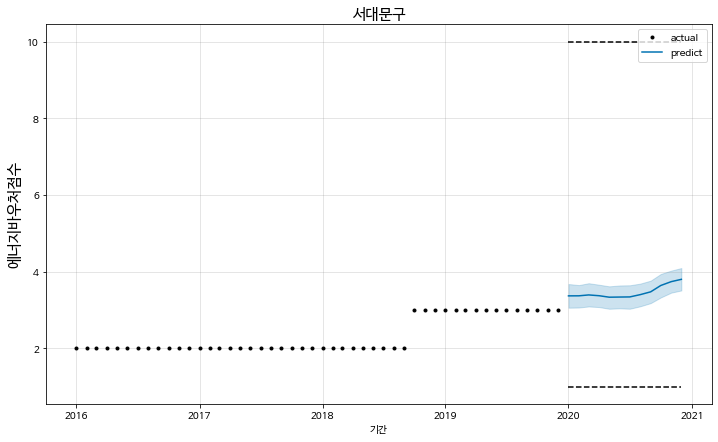

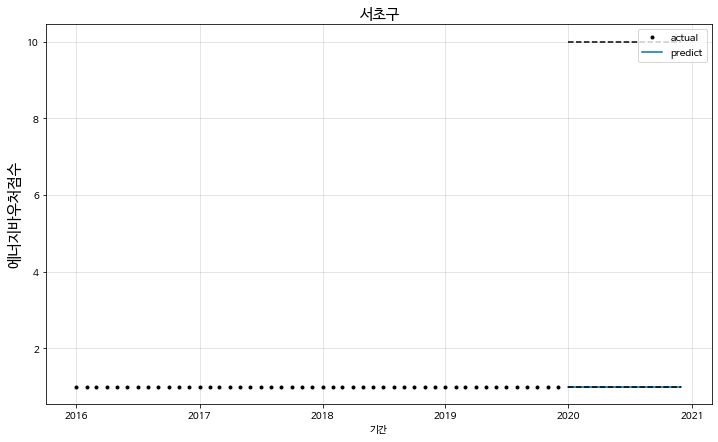

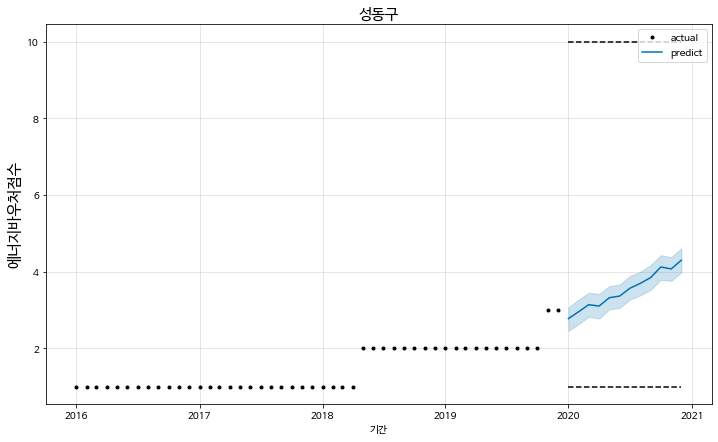

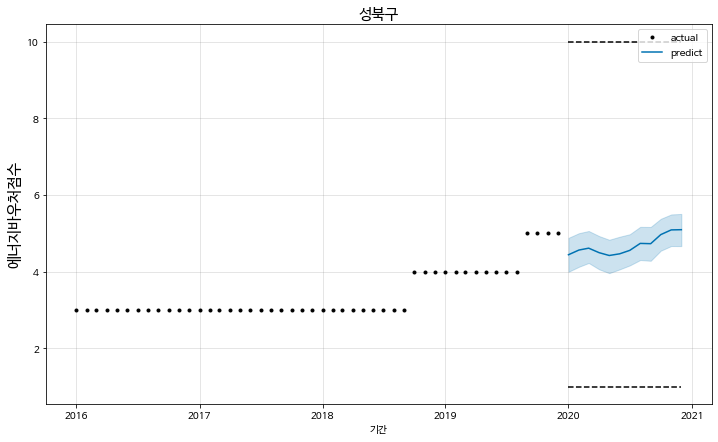

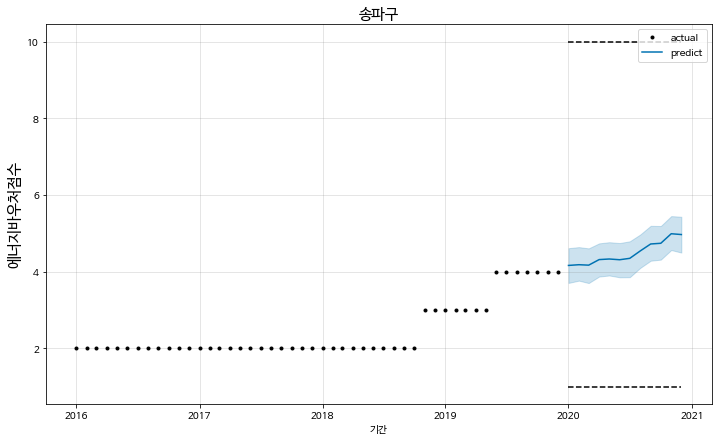

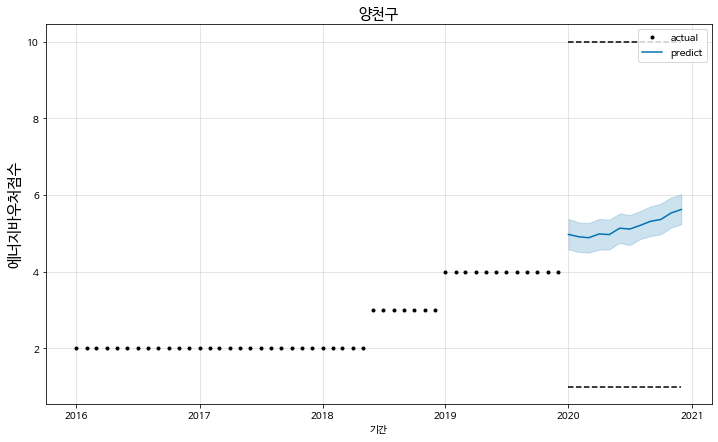

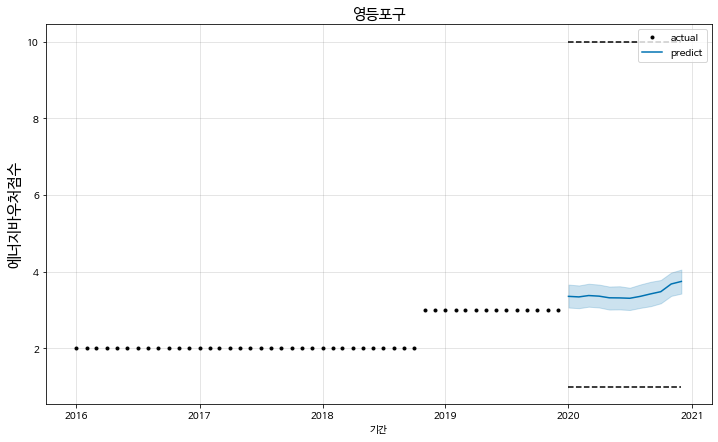

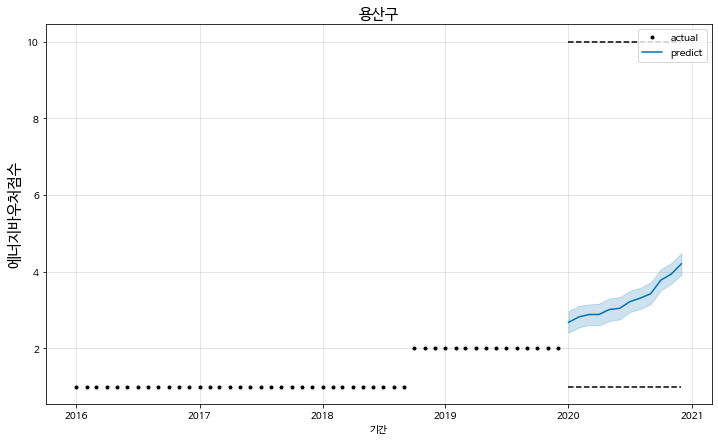

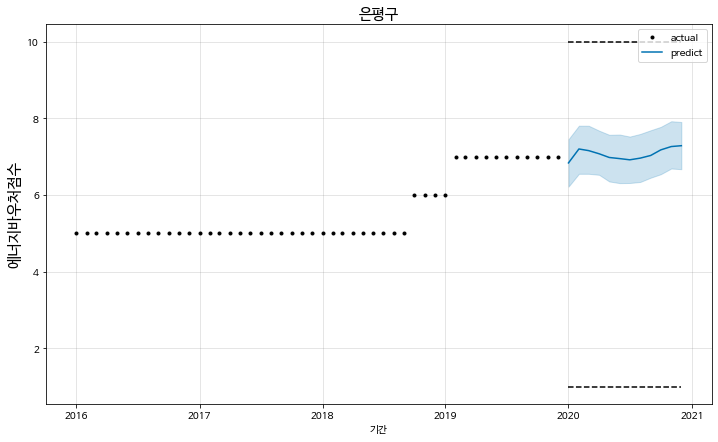

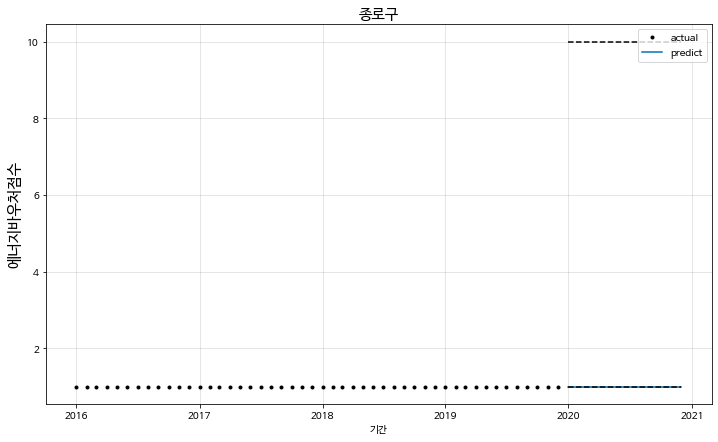

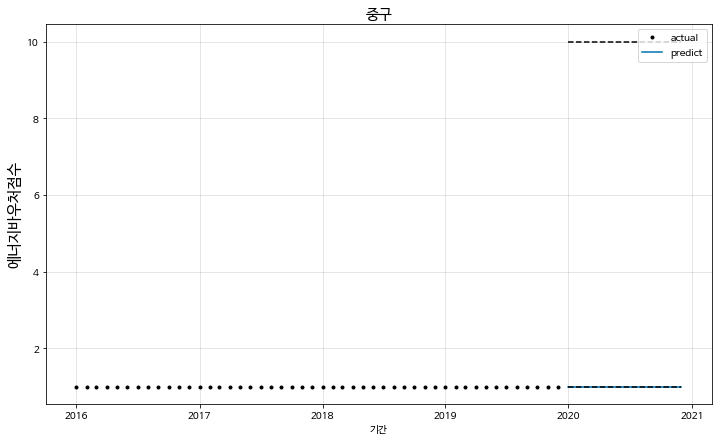

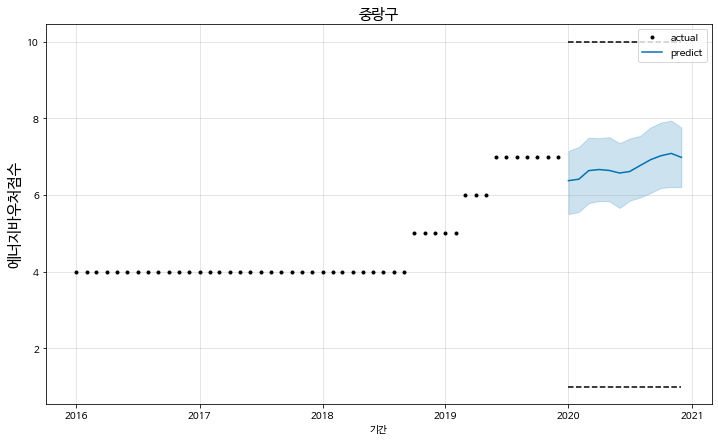

In [9]:
from fbprophet import Prophet

guCode = np.arange(1, 26)
pred = []

for gu in guCode: # 자치구별로 학습
  gu_single = df[df["구별코드"] == gu]
  train_data = gu_single[["연월_datetime", "에너지바우처점수"]]
  train_data.columns = ['ds', 'y'] # prophet모델은 컬럼명을 ds, y로 변경해야함

  # 모델생성
  model = Prophet(growth = 'logistic') 
  # 상한, 하한 설정
  train_data['cap'] = 10
  train_data['floor'] = 1
  
  # 학습
  model.fit(train_data)

  year_2020['cap'] = 10
  year_2020['floor'] = 1
  # 예측
  forecast = model.predict(year_2020)
  pred.append(forecast)

  # 시각화
  model.plot(forecast) # 라이브러리에서 시각화기능 제공
  plt.title(guList[gu-1], fontsize=15)
  plt.xlabel('기간')
  plt.ylabel('에너지바우처점수', fontsize=15)
  plt.legend(["actual", "predict"], loc='upper right')

plt.show()

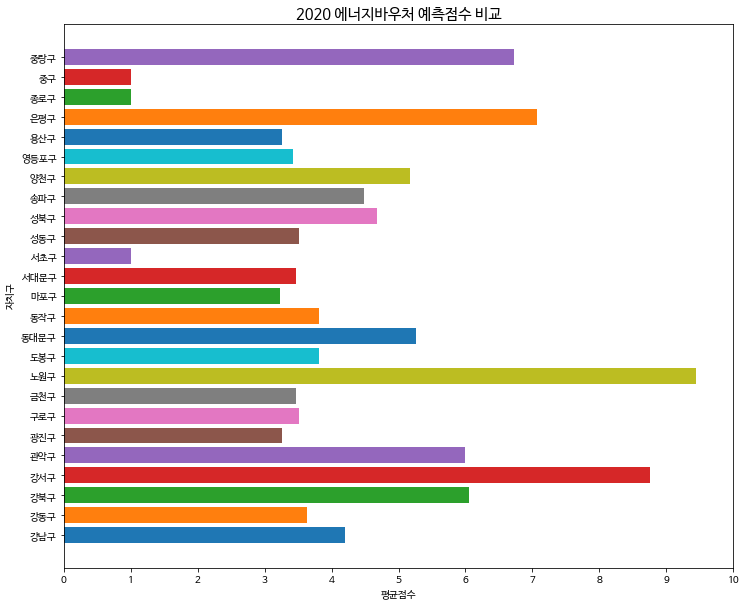

In [ ]:
# 2020년 에너지바우처 평균점수 비교

plt.figure(figsize=(12, 10))
ax = plt.subplot(1,1,1)

for gu in range(0, 25):
  gu_single = pred[gu]
  plt.barh(gu, sum(gu_single.yhat)/12)
  
plt.title("2020 에너지바우처 예측점수 비교", fontsize=15)
plt.xlabel('평균점수')
plt.ylabel('자치구')
plt.xticks(np.arange(0,11))
plt.yticks(np.arange(0,25), labels=guList, rotation=0)
plt.show()

In [ ]:
# 파일저장
test = pred[0]
eVoucher2020 = test[["ds","yhat"]]
cols = ["ds", "강남구"]
eVoucher2020.colums = cols
for gu in range(1, 25):
  gu_single = pred[gu]
  eVoucher2020 = pd.concat([eVoucher2020, gu_single[["yhat"]]], axis=1)
  cols.append(guList[gu])
  

eVoucher2020.columns = cols
eVoucher2020
# eVoucher2020.pivot(index=guList, columns='ds')

eVoucher2020.to_csv("에너지바우처2020_예측.csv", encoding='cp949')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



### 2020 최소에너지점수 예측


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarn

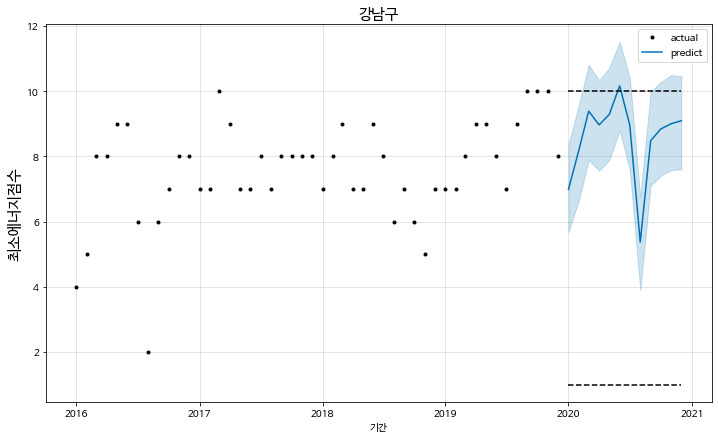

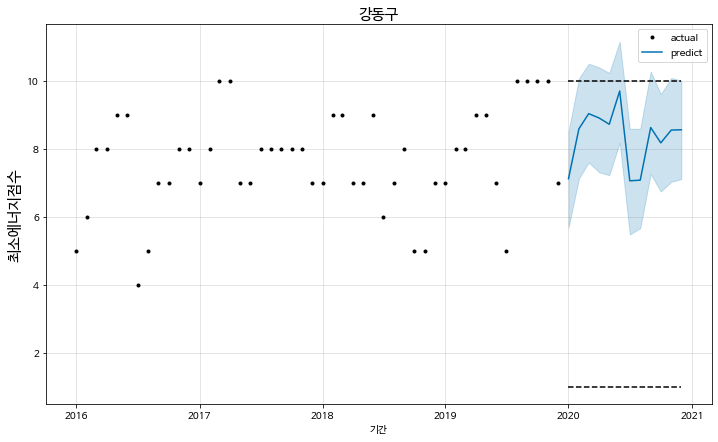

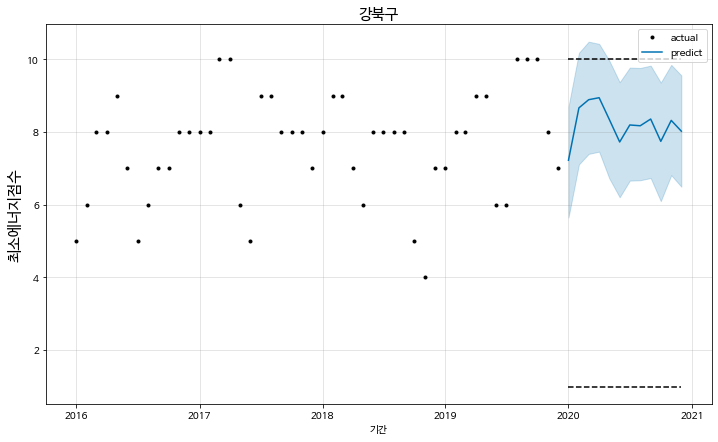

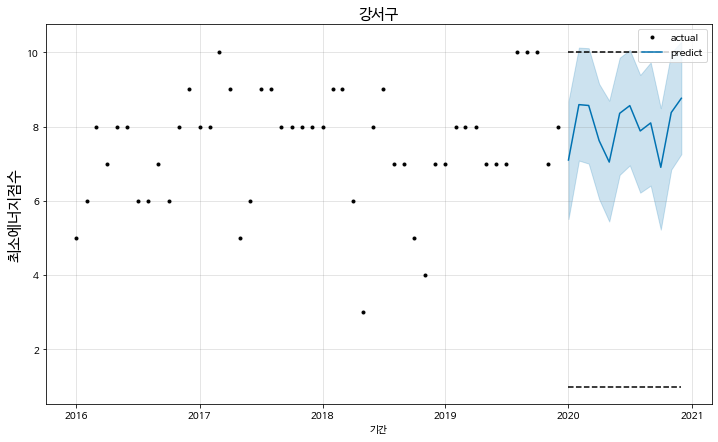

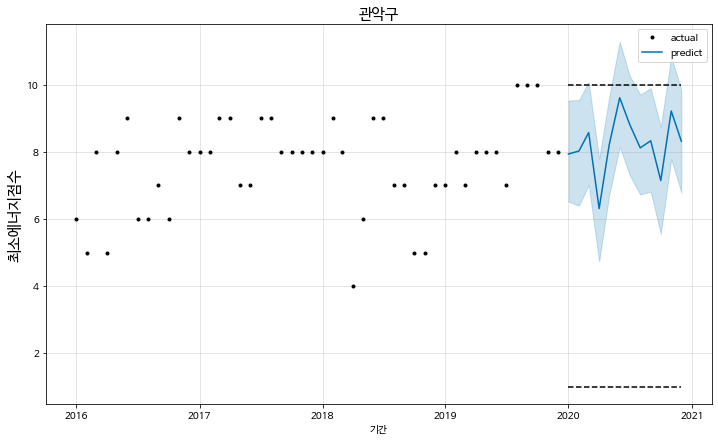

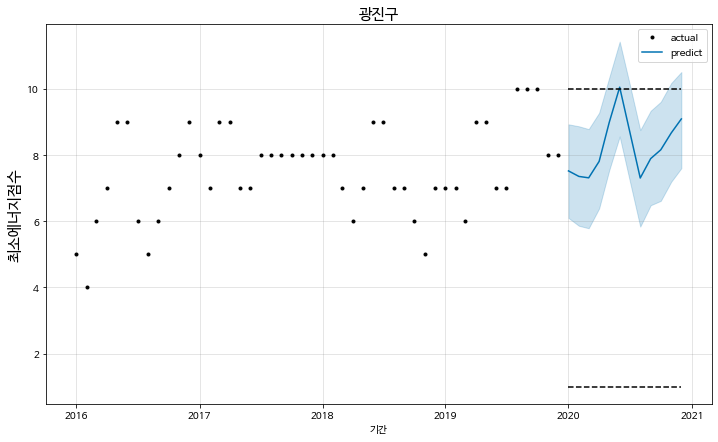

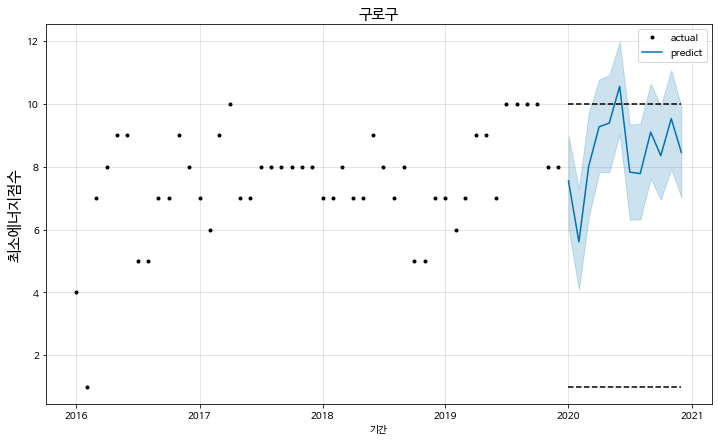

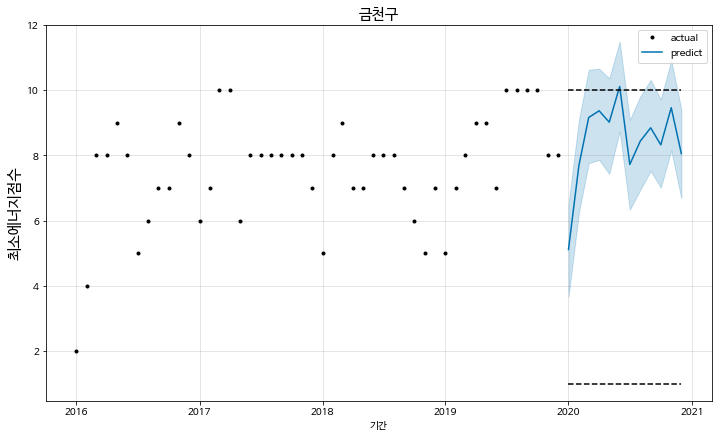

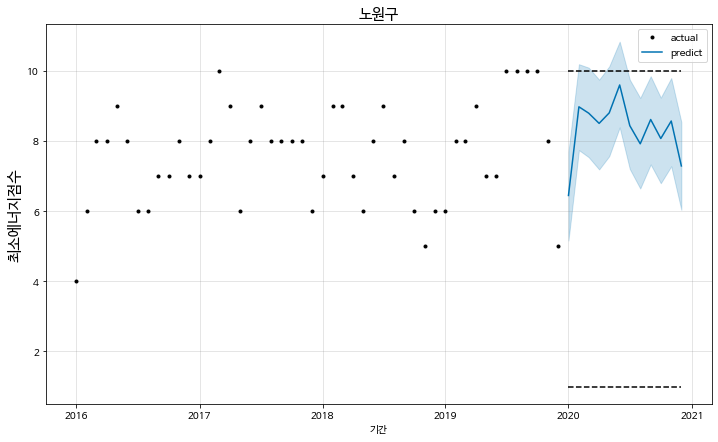

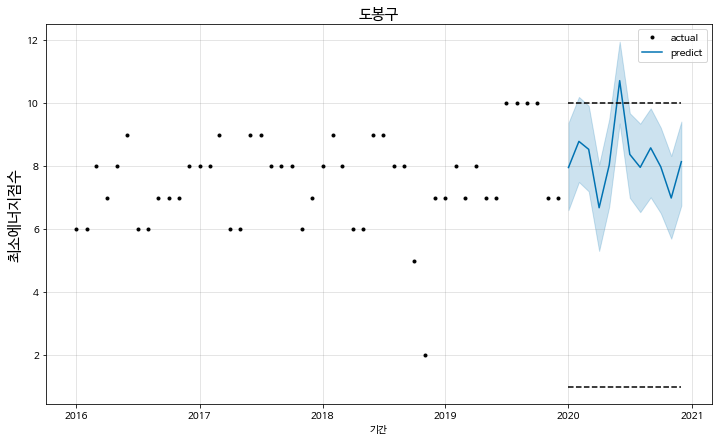

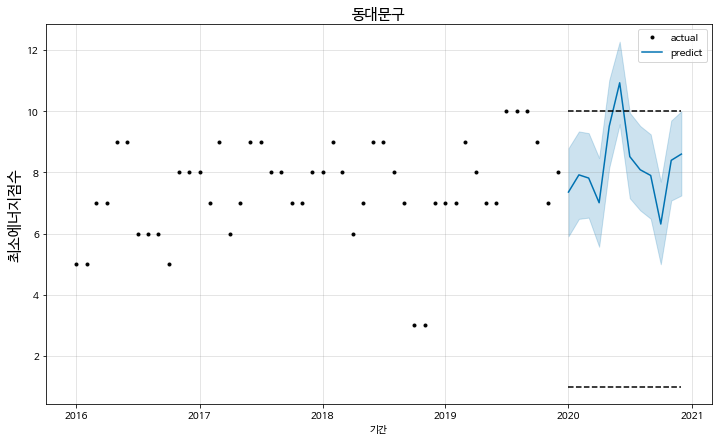

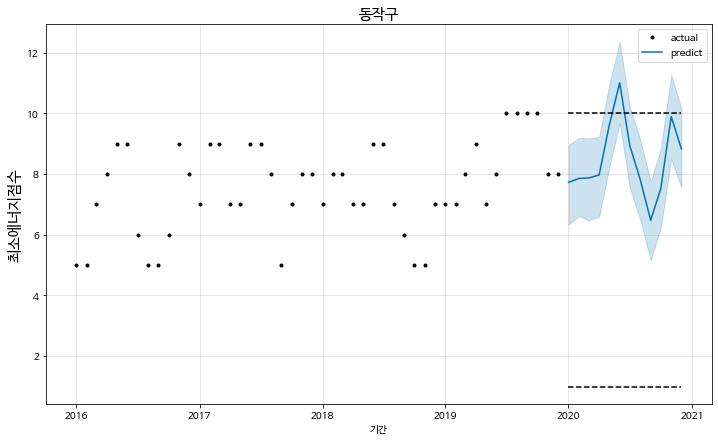

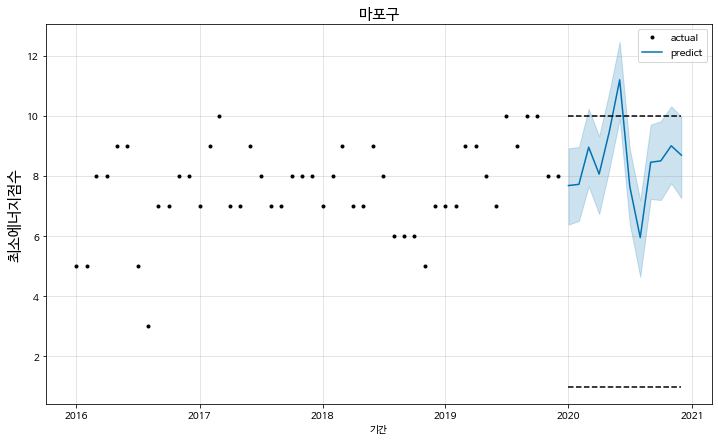

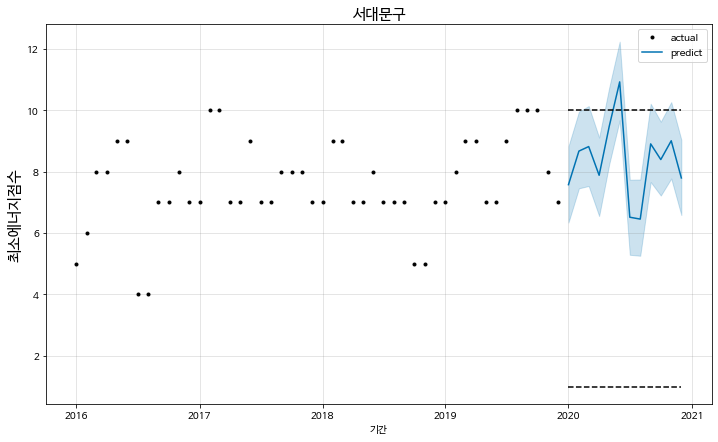

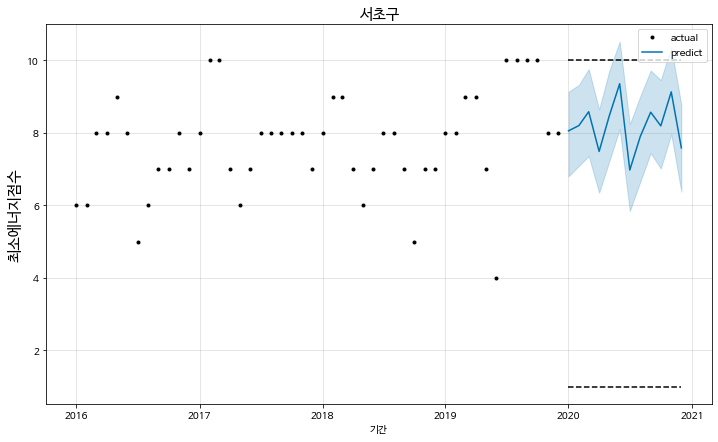

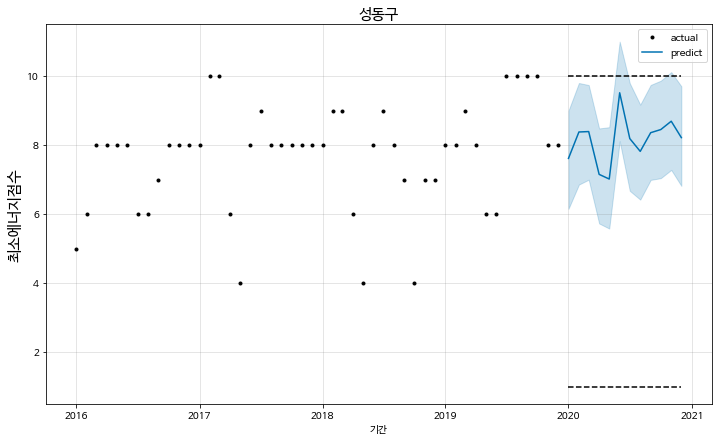

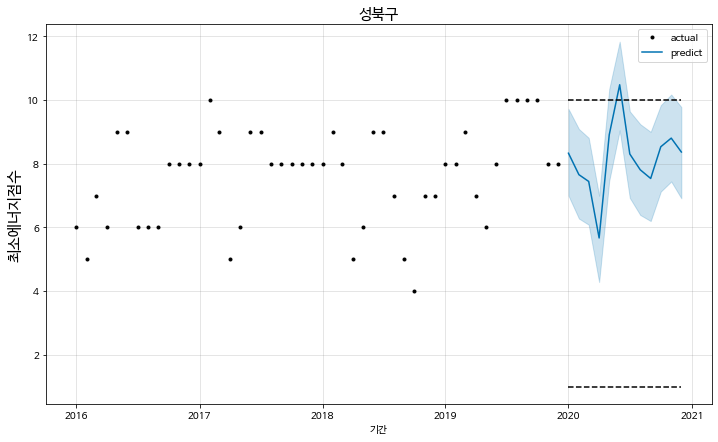

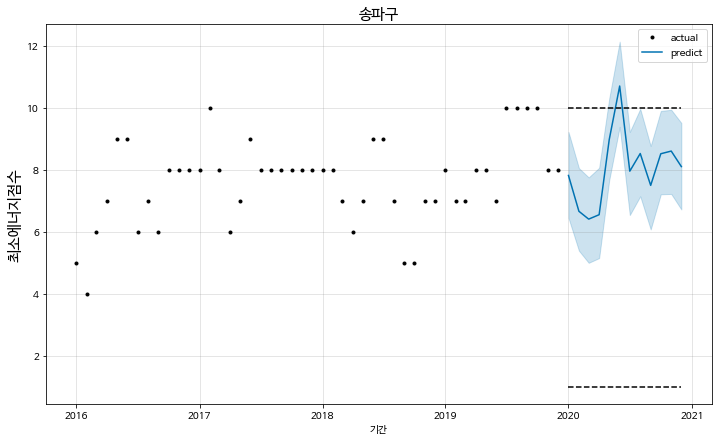

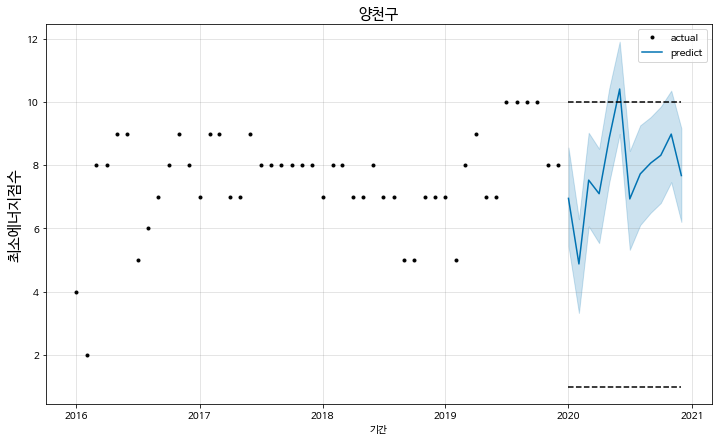

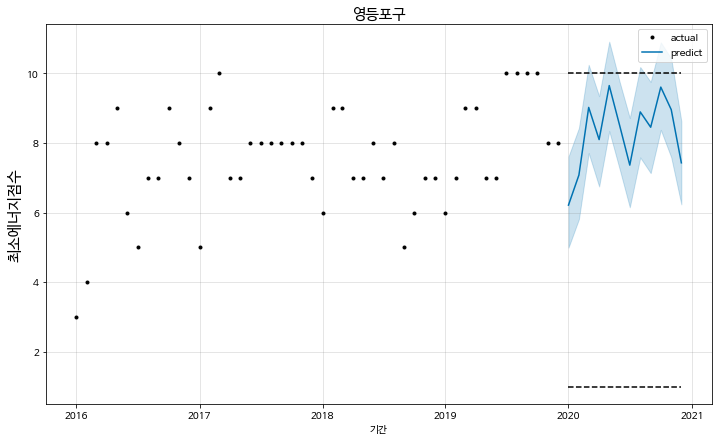

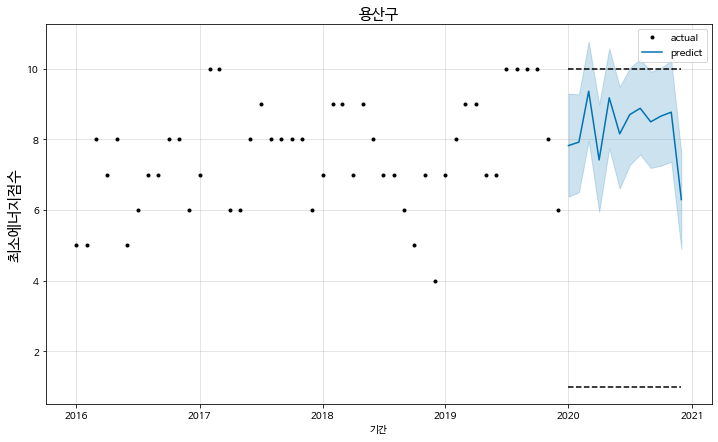

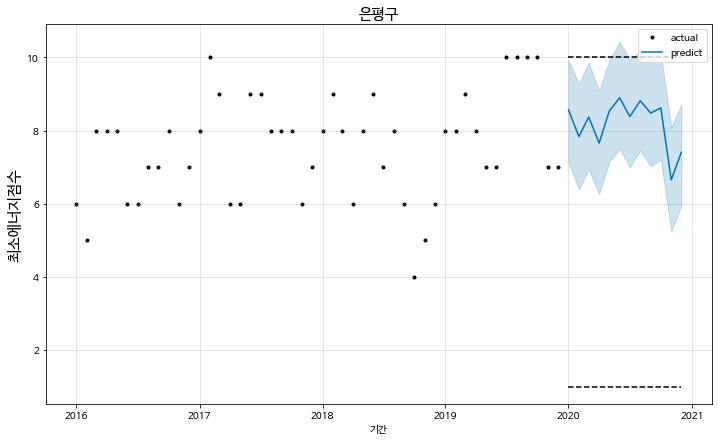

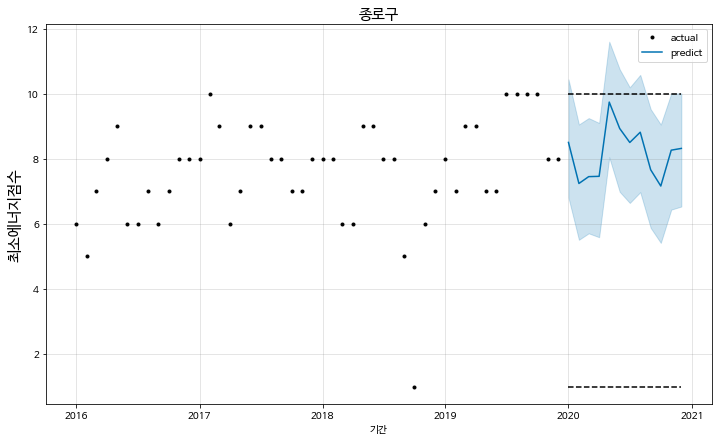

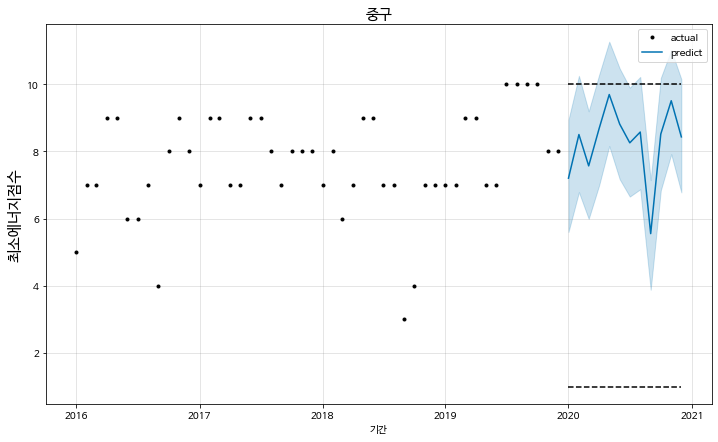

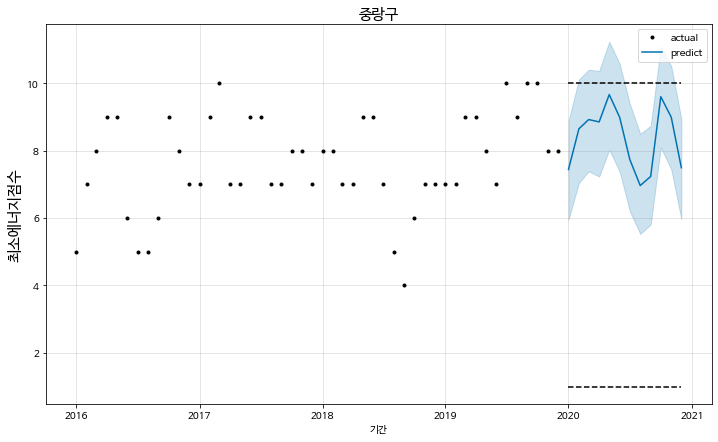

In [ ]:
from fbprophet import Prophet

guCode = np.arange(1, 26)
pred_minEnergy = []

for gu in guCode: # 구별 데이터로 학습
  
  gu_single = df[df["구별코드"] == gu]
  train_data = gu_single[["연월_datetime", "최소에너지점수"]]
  train_data.columns = ['ds', 'y'] # prophet모델은 컬럼명을 ds, y로 변경

  # 모델생성
  model = Prophet(growth = 'logistic')
  train_data['cap'] = 10 # 상한설정: 10점
  train_data['floor'] = 1 # 하한설정: 1점

  # 학습
  model.fit(train_data)

  # 예측
  year_2020['cap'] = 10
  year_2020['floor'] = 1
  forecast = model.predict(year_2020)
  pred_minEnergy.append(forecast)

  # 시각화
  model.plot(forecast) # 라이브러리에서 시각화기능 지원
  plt.title(guList[gu-1], fontsize=15)
  plt.legend(["actual", "predict"], loc='upper right')
  plt.xlabel('기간')
  plt.ylabel('최소에너지점수', fontsize=15)
  
plt.show()

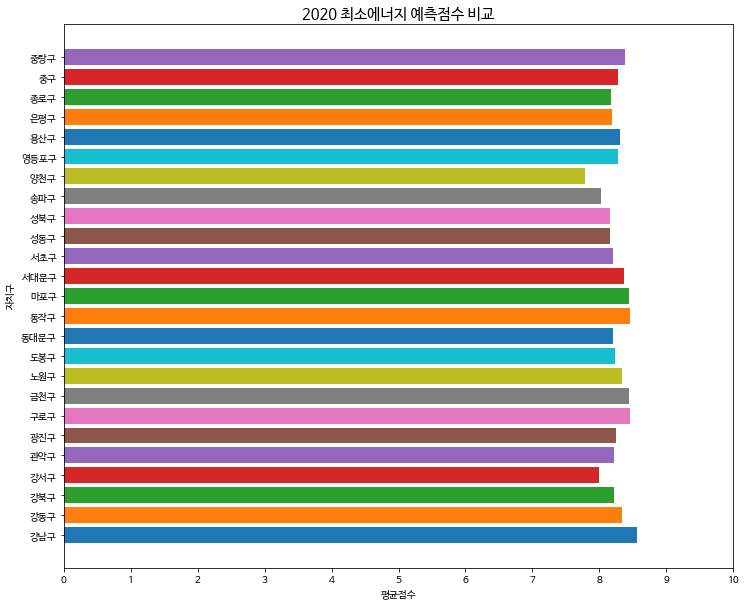

In [ ]:
# 2020년 최소에너지 평균점수 비교
plt.figure(figsize=(12, 10))
ax = plt.subplot(1,1,1)

for gu in range(0, 25):
  gu_single = pred_minEnergy[gu]
  plt.barh(gu, sum(gu_single.yhat)/12)
  
plt.title("2020 최소에너지 예측점수 비교", fontsize=15)
plt.xlabel('평균점수')
plt.ylabel('자치구')
plt.xticks(np.arange(0,11))
plt.yticks(np.arange(0,25), labels=guList, rotation=0)
plt.show()

In [ ]:
# 파일저장
test = pred_minEnergy[0]
minEnergy2020 = test[["ds","yhat"]]
cols = ["ds", "강남구"]
minEnergy2020.colums = cols
for gu in range(1, 25):
  gu_single = pred_minEnergy[gu]
  minEnergy2020 = pd.concat([minEnergy2020, gu_single[["yhat"]]], axis=1)
  cols.append(guList[gu])
  
minEnergy2020.columns = cols
minEnergy2020

minEnergy2020.to_csv("최소에너지2020_예측.csv", encoding='cp949')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



### 2020 연료비비율 점수예측

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarn

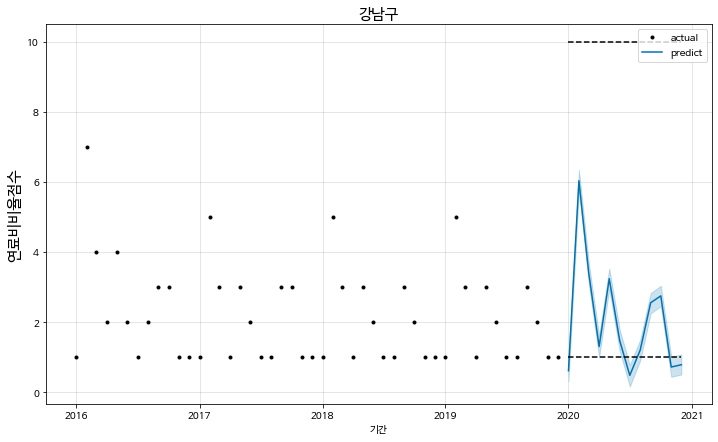

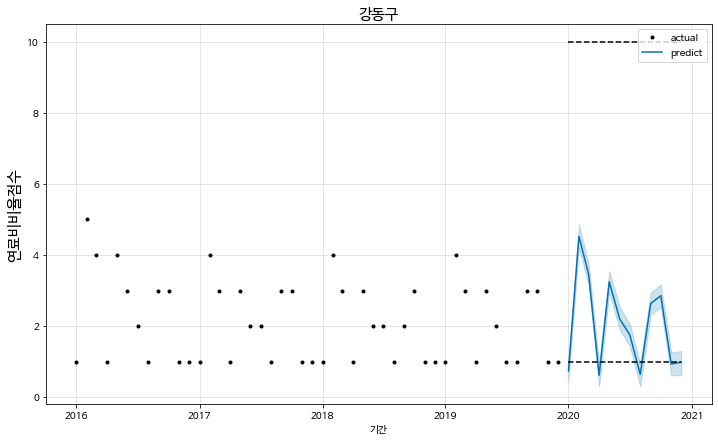

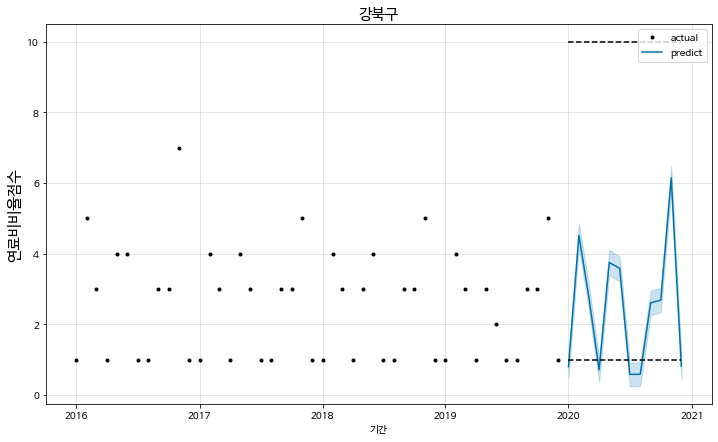

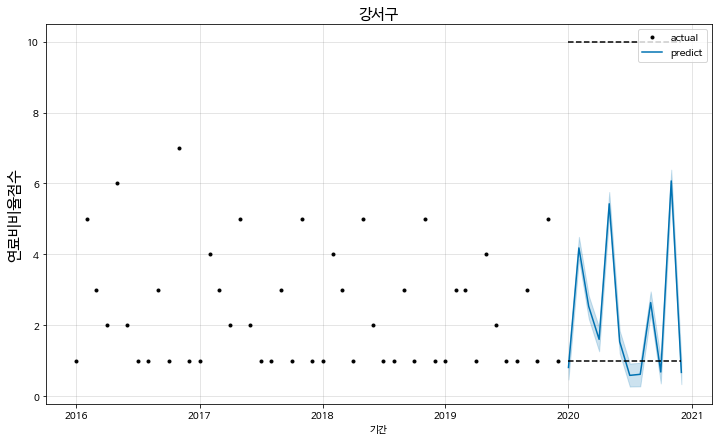

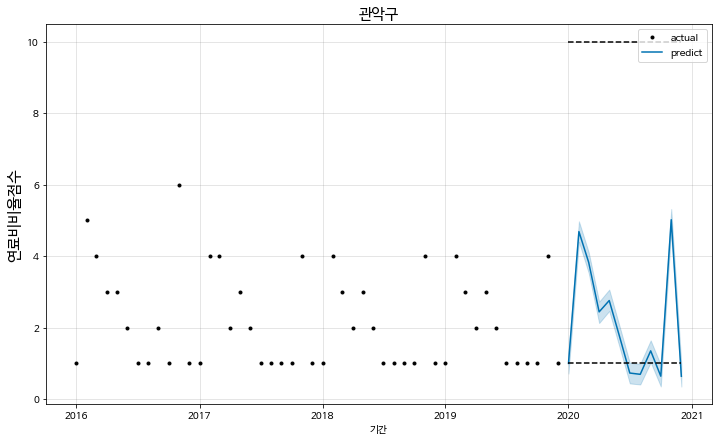

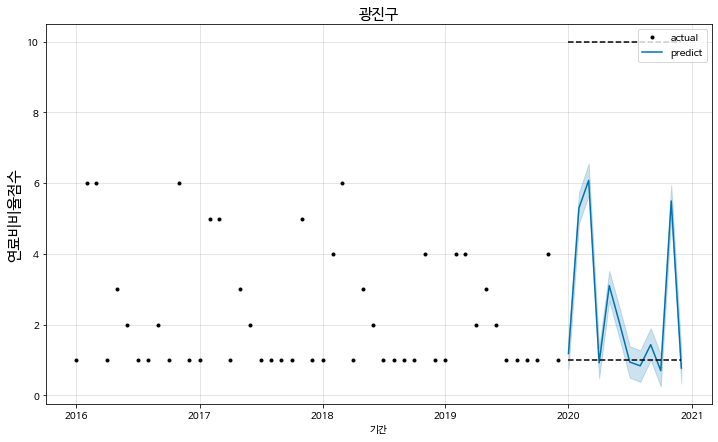

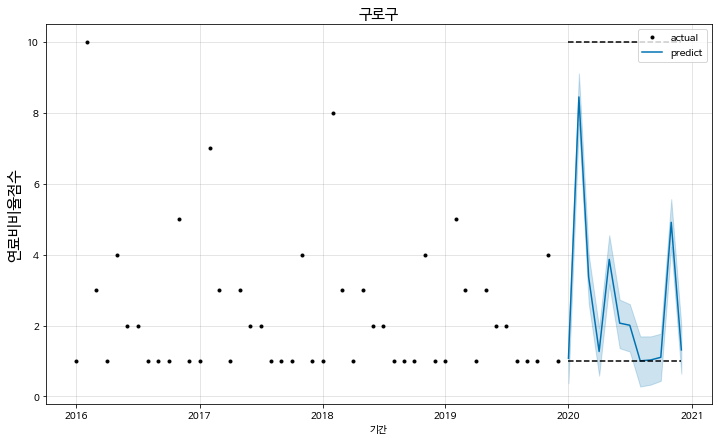

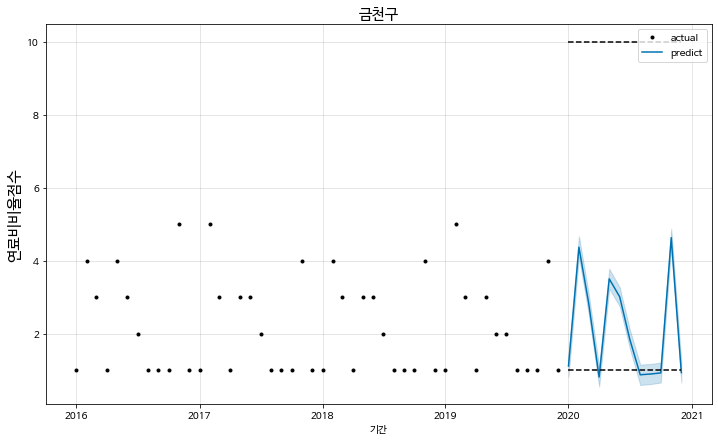

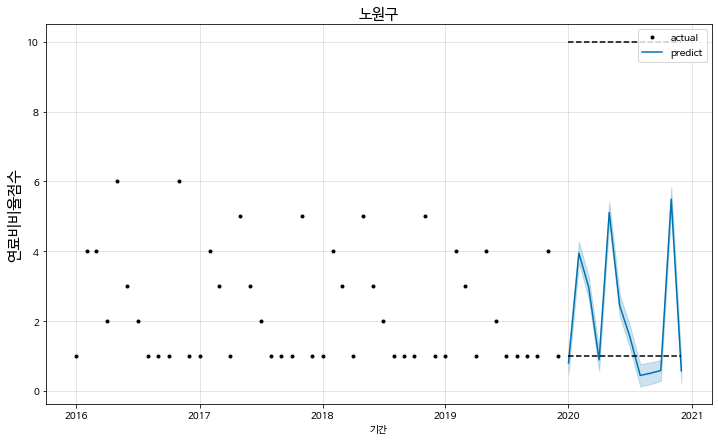

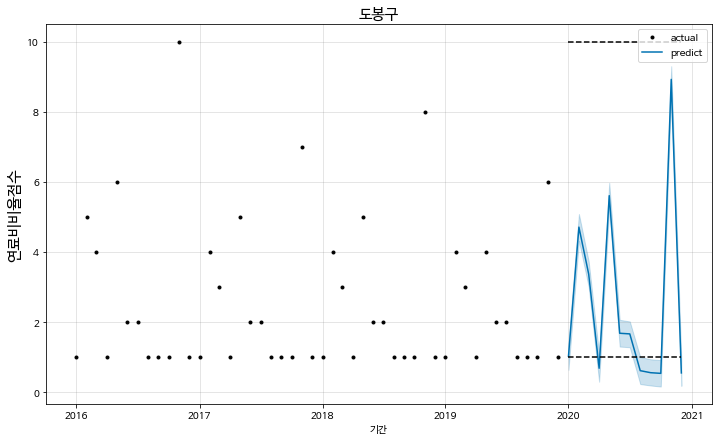

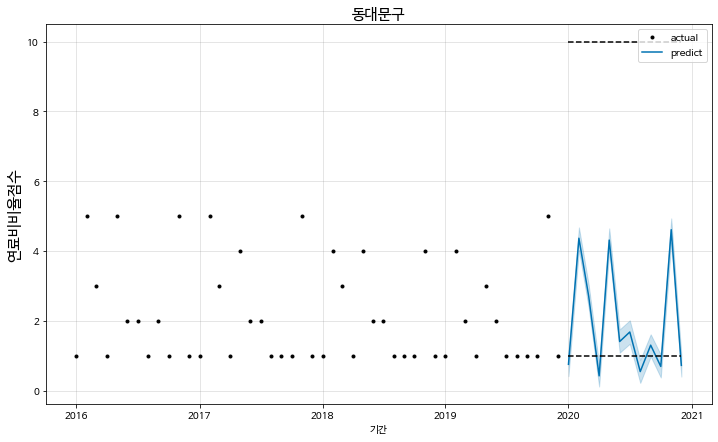

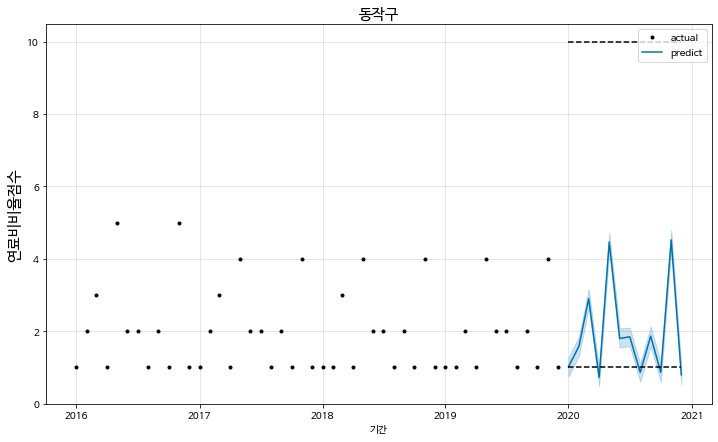

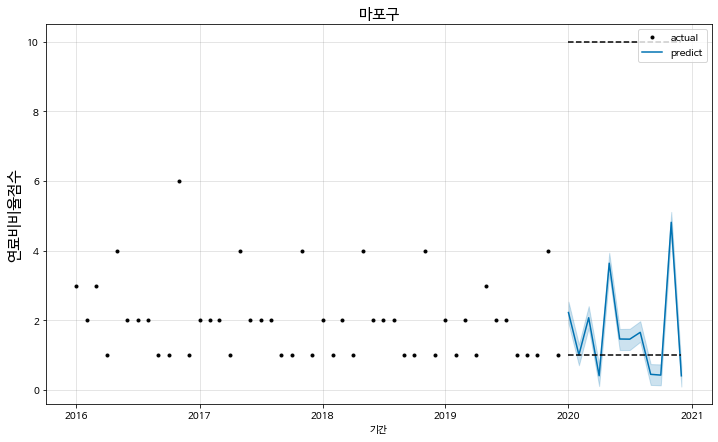

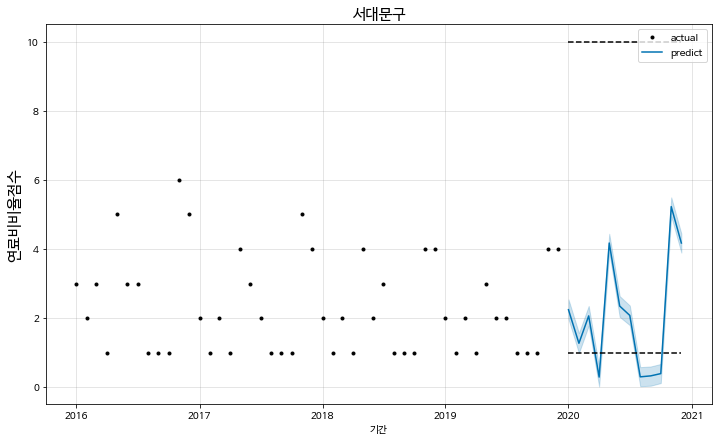

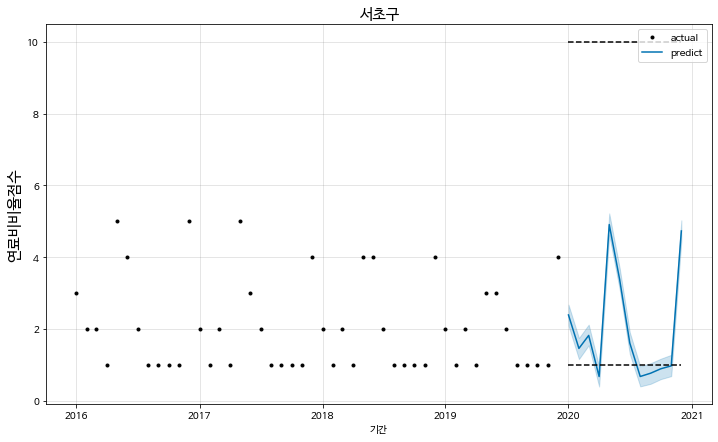

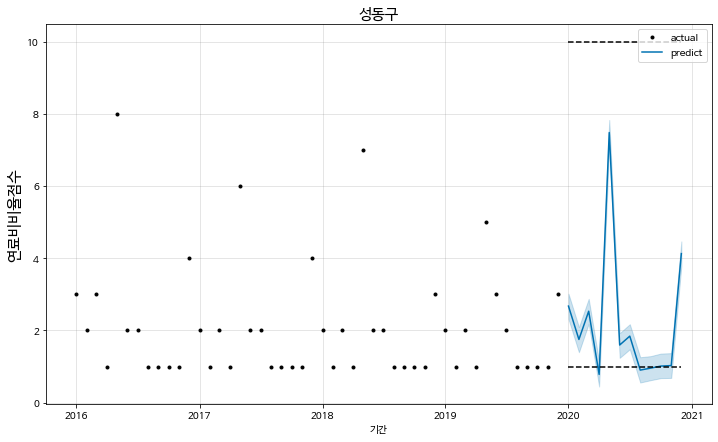

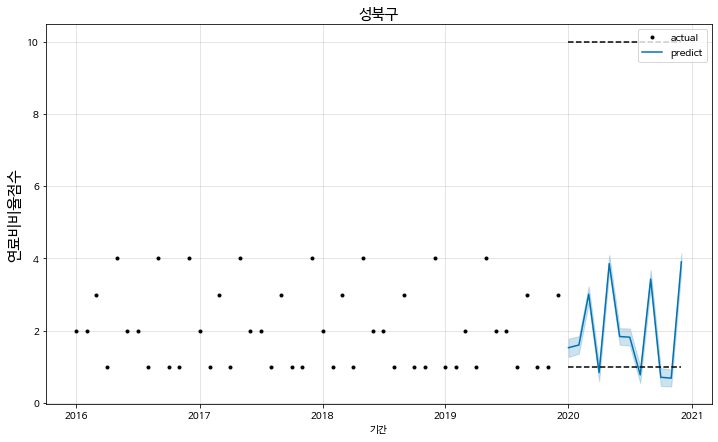

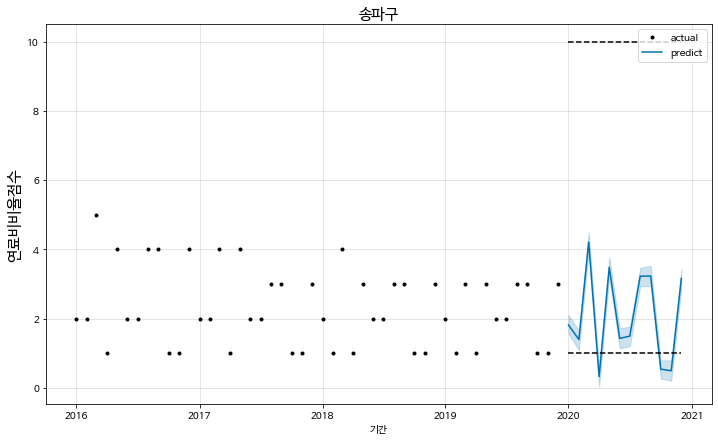

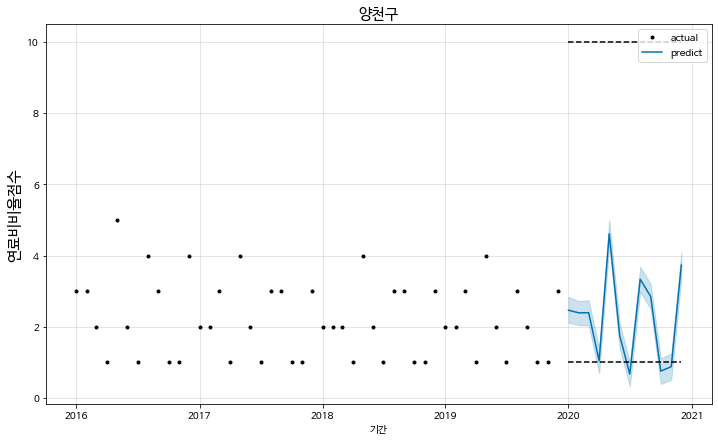

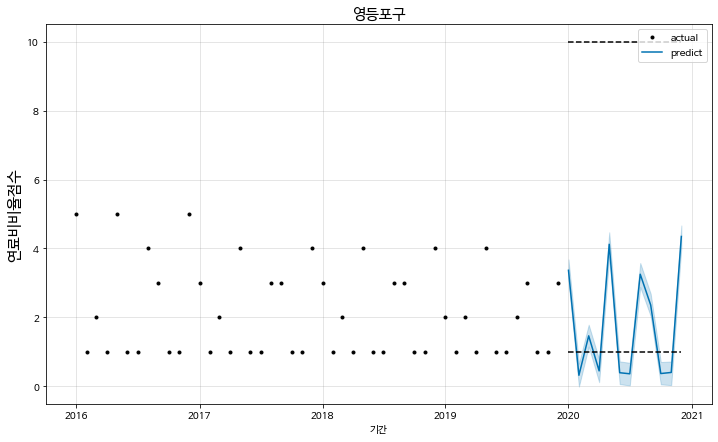

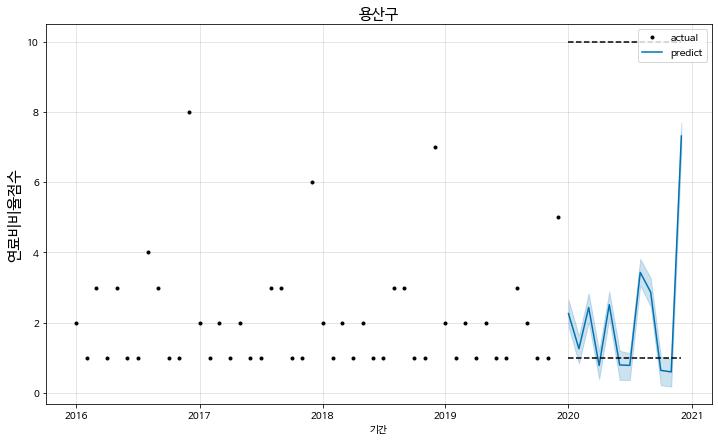

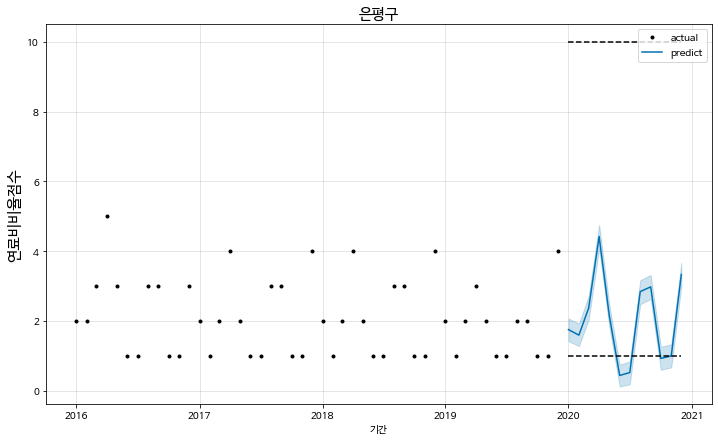

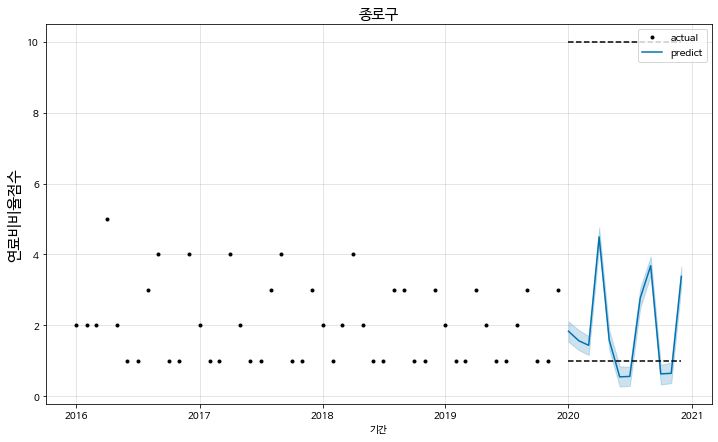

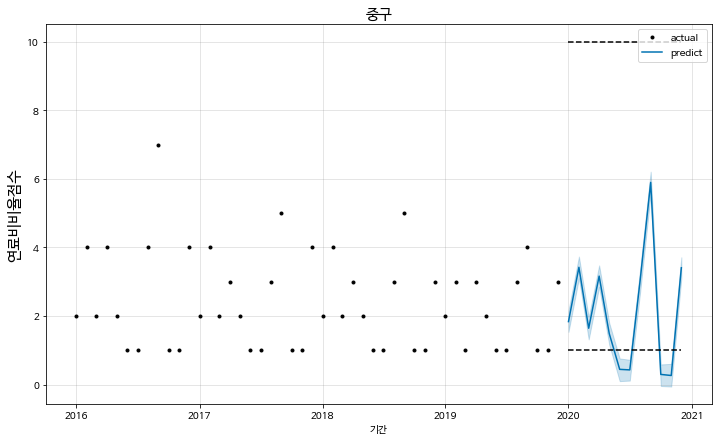

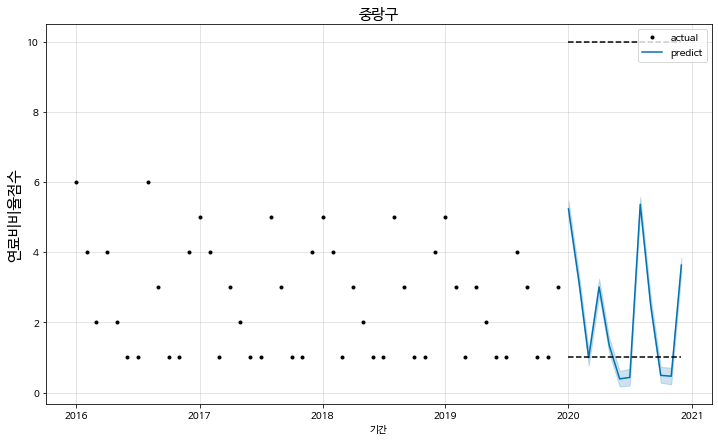

In [ ]:
# 2020 연료비비율 예측

guCode = np.arange(1, 26)

pred_eRatio = []

for gu in guCode:
  # 구별 데이터로 학습
  gu_single = df[df["구별코드"] == gu]
  train_data = gu_single[["연월_datetime", "연료비비율점수"]]
  train_data.columns = ['ds', 'y'] # prophet모델은 컬럼명을 ds, y로 변경해주어야함, ds-datetime

  model = Prophet(growth = 'logistic')
  # 상한, 하한 설정
  train_data['cap'] = 10
  train_data['floor'] = 1
  model.fit(train_data)

  # 예측
  year_2020['cap'] = 10
  year_2020['floor'] = 1
  forecast = model.predict(year_2020)
  pred_eRatio.append(forecast)

  # 시각화
  model.plot(forecast)
  plt.title(guList[gu-1], fontsize=15)
  plt.xlabel('기간')
  plt.ylabel('연료비비율점수', fontsize=15)
  plt.legend(["actual", "predict"], loc='upper right')

plt.show()

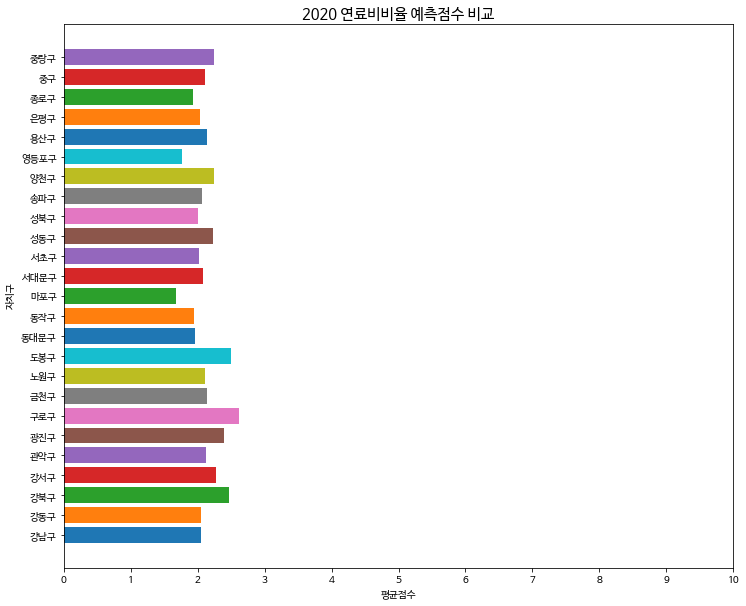

In [ ]:
# 2020년 연료비비율 평균점수 비교
plt.figure(figsize=(12, 10))
ax = plt.subplot(1,1,1)

for gu in range(0, 25):
  gu_single = pred_eRatio[gu]
  plt.barh(gu, sum(gu_single.yhat)/12)
  
plt.title("2020 연료비비율 예측점수 비교", fontsize=15)
plt.xlabel('평균점수')
plt.ylabel('자치구')
plt.xticks(np.arange(0,11))
plt.yticks(np.arange(0,25), labels=guList, rotation=0)
plt.show()

In [ ]:
# 파일저장
test = pred_eRatio[0]
eRatio2020 = test[["ds","yhat"]]
cols = ["ds", "강남구"]
eRatio2020.colums = cols
for gu in range(1, 25):
  gu_single = pred_eRatio[gu]
  eRatio2020 = pd.concat([eRatio2020, gu_single[["yhat"]]], axis=1)
  cols.append(guList[gu])
  
eRatio2020.columns = cols
eRatio2020

eRatio2020.to_csv("연료비비율2020_예측.csv", encoding='cp949')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



### 2020 에너지빈곤층 점수합산

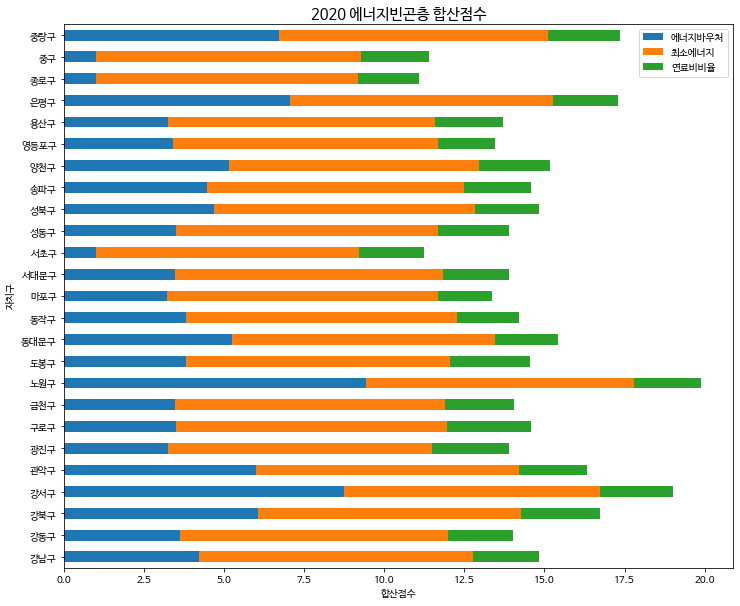

In [ ]:
# 2020년 합산점수 비교 - barh 차트 누적
# plt.figure(figsize=(25, 15))
# ax = plt.subplot(1,1,1)

eV_2020 = []
mE_2020 = []
eR_2020 = []

for gu in range(0, 25):

  gu_single_eVoucher = pred[gu]
  # plt.barh(gu, sum(gu_single_eVoucher.yhat)/12, color='skyblue')
  eV_2020.append(sum(gu_single_eVoucher.yhat)/12)

  gu_single_minEnergy = pred_minEnergy[gu]
  # plt.barh(gu, sum(gu_single_minEnergy.yhat)/12, color='green')
  mE_2020.append(sum(gu_single_minEnergy.yhat)/12)

  gu_single_eRatio = pred_eRatio[gu]
  # plt.barh(gu, sum(gu_single_eRatio.yhat)/12, color='orange')
  eR_2020.append(sum(gu_single_eRatio.yhat)/12)

df = pd.DataFrame({'eVoucher' : eV_2020,'minEnergy' : mE_2020, 'eRatio' : eR_2020})
ax = df.plot.barh(stacked=True);
ax.figure.set_size_inches(12,10)

plt.title("2020 에너지빈곤층 합산점수", fontsize=15)
plt.xlabel('합산점수')
plt.ylabel('자치구')
# plt.xticks(np.arange(0,21))
plt.yticks(np.arange(0,25), labels=guList, rotation=0)
plt.legend(['에너지바우처', '최소에너지', '연료비비율'],loc='upper right')
plt.show()

In [ ]:
# 순위계산
# pred_eRatio[0].yhat.mean() # 2.0514011598904425

avg2020 = []
for gu in range(0, 25):

  gu_eVoucher2020 = pred[gu]
  gu_eVoucher2020_avg = gu_eVoucher2020.yhat.mean()

  gu_minEnergy2020 = pred_minEnergy[gu]
  gu_minEnergy2020_avg = gu_minEnergy2020.yhat.mean()

  gu_eRatio2020 = pred_eRatio[gu]
  gu_eRatio2020_avg = gu_eRatio2020.yhat.mean()

  gu_sum = gu_eVoucher2020_avg + gu_minEnergy2020_avg + gu_eRatio2020_avg

  avg2020.append([gu, gu_sum])

df_avg2020 = pd.DataFrame(avg2020)
df_avg2020.columns = ["구코드", "2020_합산점수"]
df_avg2020 = df_avg2020.sort_values(by=['2020_합산점수'], axis=0, ascending=False)
df_avg2020['rank'] = df_avg2020['2020_합산점수'].rank(method='first', ascending=False)
df_avg2020

,구코드,2020_합산점수,rank
8,8,19.899678,1.0
3,3,19.027066,2.0
24,24,17.356332,3.0
21,21,17.285308,4.0
2,2,16.742299,5.0
4,4,16.339682,6.0
10,10,15.416119,7.0
18,18,15.190241,8.0
16,16,14.831391,9.0
0,0,14.823082,10.0


In [ ]:
df_avg2020.describe()

,구코드,2020_합산점수
count,25.000000,25.000000
mean,13.000000,14.754162
std,7.359801,2.144695
min,1.000000,11.102145
25%,7.000000,13.895578
50%,13.000000,14.540809
75%,19.000000,15.416119
max,25.000000,19.899678


In [ ]:
tt = df_avg2020.iloc[1]
tt['구코드']

4.0

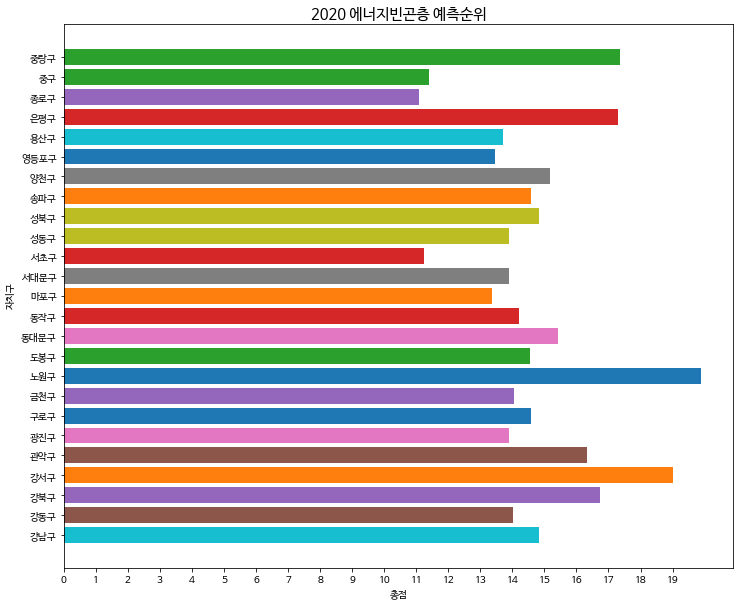

In [ ]:
# 순위계산-시각화

plt.figure(figsize=(12, 10))
ax = plt.subplot(1,1,1)

# plt.barh(df_avg2020["구코드"], df_avg2020["2020_합산점수"])
for gu in range(0, 25):
  gu_single = df_avg2020.iloc[gu]
  plt.barh(gu_single['구코드'], gu_single['2020_합산점수'])

  
plt.title("2020 에너지빈곤층 예측순위", fontsize=15)
plt.xlabel('총점')
plt.ylabel('자치구')
plt.xticks(np.arange(0,20))
plt.yticks(np.arange(0,25), labels=guList, rotation=0)
plt.show()

In [ ]:
forecast.columns # yhat-예측값, yhat_lower-하한, yhat_upper-상한

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [ ]:
forecast.yhat

0     4.238025
1     4.304475
2     4.359937
3     4.420006
4     4.494835
5     4.542876
6     4.591854
7     4.629077
8     4.681883
9     4.798457
10    4.916679
11    4.965109
Name: yhat, dtype: float64

### 2019년 실제값과 예측값 비교(모델평가)

**MAE (Mean Absolute Error)**

- 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화

- MAE는 에러에 절대값을 취하기 때문에 에러의 크기 그대로 반영된다. 그러므로 예측 결과물의 에러가 10이 나온 것이 5로 나온 것보다 2배가 나쁜 도메인에서 쓰기 적합한 산식이다.

- 에러에 따른 손실이 선형적으로 올라갈 때, 이상치가 많을 때 적합

**MSE (Mean Squared Error)**

- 실제 값과 예측 값의 차이를 제곱해 평균화
- 예측값과 실제값 차이의 면적의 합
- 특이값이 존재하면 수치가 많이 늘어난다.

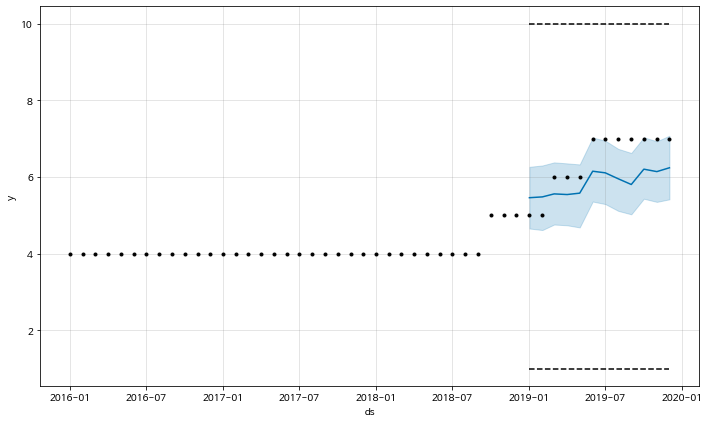

In [ ]:
# 2019
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 2019 예측
last_1year['cap'] = 10
last_1year['floor'] = 1
forecast = model.predict(last_1year)

model.plot(forecast)
plt.show()
# 검은색 점이 실제값, 하늘색범위가 예측값

In [ ]:
# 예측값과 실제값으로 MSE 구하기

y_true = train_data['y'][-12:].values
forecast = model.predict(last_1year)
y_pred = forecast['yhat'].values

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % np.sqrt(mse))

MAE: 0.723
MSE: 0.586
RMSE: 0.766


### 연도별 합산점수 변화 시각화

In [ ]:
df_eV2020 = pd.read_csv("에너지바우처2020_예측.csv", encoding='cp949')
df_eV2020_avg = df_eV2020.mean()

df_mE2020 = pd.read_csv("최소에너지2020_예측.csv", encoding='cp949')
df_mE2020_avg = df_mE2020.mean()

df_eR2020 = pd.read_csv("연료비비율2020_예측.csv", encoding='cp949')
df_eR2020_avg = df_eR2020.mean()

df_pred2020 = df_eV2020_avg + df_mE2020_avg + df_eR2020_avg
df_pred2020 = pd.DataFrame(df_pred2020)
df_pred2020 = df_pred2020.iloc[0:-1]
df_pred2020.columns = ["점수합계"]
df_pred2020["연도"] = 2020

# 구 단위 코드화; 강남구-1, 중랑구-25
code = 1
for gu in guList:
  df_pred2020.loc[(df_pred2020.index == gu), "구별코드"] = code
  code += 1


df_pred2020 = df_pred2020[["점수합계", "연도", "구별코드"]].dropna()

df_pred2020.loc['중랑구'] = [16.500000, 2020, 25]
df_pred2020


,점수합계,연도,구별코드
강남구,14.823082,2020.0,1.0
강동구,14.026539,2020.0,2.0
강북구,16.742299,2020.0,3.0
강서구,19.027066,2020.0,4.0
관악구,16.339682,2020.0,5.0
광진구,13.905234,2020.0,6.0
구로구,14.589683,2020.0,7.0
금천구,14.047107,2020.0,8.0
노원구,19.899678,2020.0,9.0
도봉구,14.540809,2020.0,10.0


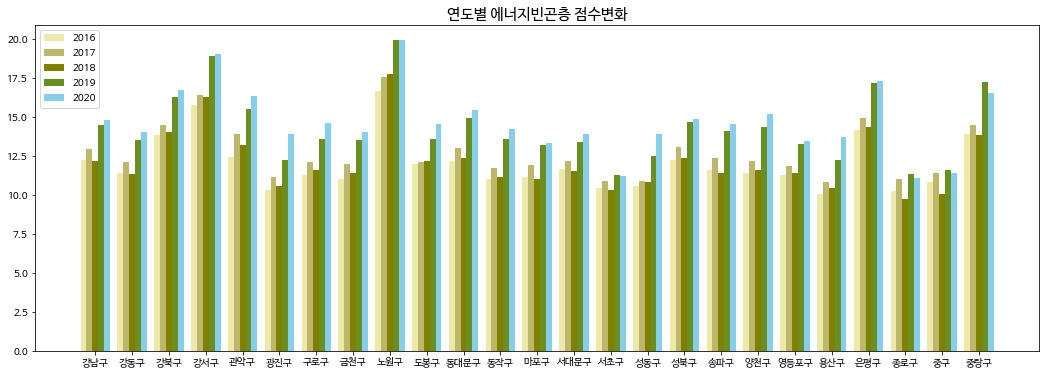

In [ ]:
# 자치구별 연평균점수
# 구별 데이터 합산 -> 12로 나눠서 평균구하기

plt.figure(figsize=(18, 6))
ax = plt.subplot(1,1,1)

# 2016
df_2016 = df[df["연도"] == '2016']
df_2016 = df_2016[["자치구명", "점수합계"]].groupby(['자치구명']).mean()
df_2016["연도"] = 2016

n = 1  # This is our first dataset (out of 4)
t = 5 # Number of dataset
d = 25 # Number of sets of bars
w = 0.8 # Width of each bar
store1_x = [t*element + w*n for element in range(d)]
ax.bar(store1_x, df_2016["점수합계"], color='palegoldenrod')


# 2017
df_2017 = df[df["연도"] == '2017']
df_2017 = df_2017[["자치구명", "점수합계"]].groupby(['자치구명']).mean()
df_2017["연도"] = 2017

n = 2  # This is our 2nd dataset (out of 4)
t = 5 # Number of dataset
d = 25 # Number of sets of bars
w = 0.8 # Width of each bar
store2_x = [t*element + w*n for element in range(d)]
ax.bar(store2_x, df_2017["점수합계"], color='darkkhaki')

# 2018
df_2018 = df[df["연도"] == '2018']
df_2018 = df_2018[["자치구명", "점수합계"]].groupby(['자치구명']).mean()
df_2018["연도"] = 2018

n = 3  # This is our nth dataset (out of 4)
t = 5 # Number of dataset
d = 25 # Number of sets of bars
w = 0.8 # Width of each bar
store3_x = [t*element + w*n for element in range(d)]
ax.bar(store3_x, df_2018["점수합계"], color='olive')

# 2019
df_2019 = df[df["연도"] == '2019']
df_2019 = df_2019[["자치구명", "점수합계"]].groupby(['자치구명']).mean()
df_2019["연도"] = 2019

n = 4  # This is our nth dataset (out of 4)
t = 5 # Number of dataset
d = 25 # Number of sets of bars
w = 0.8 # Width of each bar
store4_x = [t*element + w*n for element in range(d)]
ax.bar(store4_x, df_2019["점수합계"], color='olivedrab')

# df_2019["점수합계"].shape

# 2020
n = 5  # This is our nth dataset (out of 4)
t = 5 # Number of dataset
d = 25 # Number of sets of bars
w = 0.8 # Width of each bar
store5_x = [t*element + w*n for element in range(d)]
ax.bar(store5_x, df_pred2020["점수합계"], color='skyblue')



# xticks 자리계산
middle_x = [(a+e)/2 for (a,e) in zip(store1_x, store5_x)]

ax.set_xticks(middle_x)
ax.set_xticklabels(guList)
ax.legend([2016, 2017, 2018, 2019, 2020])
plt.title("연도별 에너지빈곤층 점수변화", fontsize=15)

plt.show()

In [ ]:
df_pred2020["rank"] = df_pred2020["점수합계"].rank(method='first', ascending=False)
df_pred2020_rank = df_pred2020.sort_values(by=['rank'], axis=0)
df_pred2020_rank["rank"] = df_pred2020_rank["rank"].apply(np.int64)
df_pred2020_rank[["점수합계", "rank"]].head()

,점수합계,rank
노원구,19.899678,1
강서구,19.027066,2
은평구,17.285308,3
강북구,16.742299,4
중랑구,16.500000,5


In [ ]:
df_pred2020_rank[["점수합계", "rank"]].tail()

,점수합계,rank
영등포구,13.461923,21
마포구,13.351608,22
중구,11.387519,23
서초구,11.237560,24
종로구,11.102145,25
